# Rotated Labeled Wafer Images

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

## Rotated [90 degrees] Silicon Wafer 1

### Load Data

In [3]:
# location of silicon wafer 1 data
dir_silicon_wafer_1 = "../dataset/silicon_wafer_1"

Prepare column names (`MultiIndex`) for reading data frame:

In [4]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

Read the labels of tissue from the file:

In [5]:
wafer_tissue_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_tissue.txt", sep="\t|,", header=None, names=index, engine='python')
print(f"Size of the Silicon Wafer 1 dataset, tissue part is {wafer_tissue_lbl.shape}")
wafer_tissue_lbl.head()

Size of the Silicon Wafer 1 dataset, tissue part is (514, 8)


point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    6785  3094    6724  2937    7103  2812    7120  2965
1    6347  3218    6275  3066    6649  2922    6675  3071
2    6037  3596    5972  3442    6352  3314    6371  3463
3    6487  3605    6399  3461    6749  3274    6793  3424
4    6858  3507    6776  3363    7136  3187    7170  3333

Read the labels of magnet from the file:

In [6]:
wafer_magnet_lbl = pd.read_csv(f"{dir_silicon_wafer_1}/source_sections_mag.txt", sep="\t|,", header=None, names=index, engine='python')
print(f"Size of the Silicon Wafer 1 dataset, magnet part is {wafer_magnet_lbl.shape}")
wafer_magnet_lbl.head()

Size of the Silicon Wafer 1 dataset, magnet part is (514, 8)


point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    6840  3232    6787  3099    7120  2968    7143  3117
1    6410  3355    6351  3225    6672  3075    6707  3217
2    6096  3733    6041  3599    6372  3467    6396  3610
3    6566  3739    6490  3609    6791  3425    6842  3564
4    6930  3636    6859  3510    7171  3336    7212  3479

### Drawing

Helper to convert hex color code to RGB code.

In [7]:
def rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

Helper to draw labels from dataframe on the image:

In [8]:
def draw_labels(image, labels_df, scale, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = (np.array([[labels_df.point_1.x[row], labels_df.point_1.y[row]],
                        [labels_df.point_2.x[row], labels_df.point_2.y[row]],
                        [labels_df.point_3.x[row], labels_df.point_3.y[row]],
                        [labels_df.point_4.x[row], labels_df.point_4.y[row]]])//scale).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)
    
    return image

Read the image of Silicon Wafer 1:

In [9]:
wafer_1 = cv.imread(f"{dir_silicon_wafer_1}/wafer_1_downsize_3.tif")
# wafer_1 = cv.resize(wafer_1, (6136, 5616))

Some general settings:

In [10]:
scale = 3
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

### Rotate the image

In [11]:
# number of pixels: rows, cols = 5616, 6136
rows, cols = wafer_1.shape[:2]
print(rows, cols)

# center of rotation (x, y)
center = (cols/2, rows/2)

# angle of couterclockwise rotation
angle = 90

# get rotation matrix, will be used in labels rotation
M = cv.getRotationMatrix2D(center, angle=angle, scale=1)
print(M)

# rotate the picture
wafer_1_rot = cv.warpAffine(wafer_1, M, (rows, cols))
print(wafer_1_rot.shape[:2])


5616 6136
[[ 6.123234e-17  1.000000e+00  2.600000e+02]
 [-1.000000e+00  6.123234e-17  5.876000e+03]]
(6136, 5616)


### Rotate the labels

In [12]:
def rotate_rectangle(label, M):
    rotate_point = lambda point, M: (M[0][0]*point.x + M[0][1]*point.y + M[0][2] + 520,  # TODO: this is hardcoded!!!! Find out why is this value like this
                                     M[1][0]*point.x + M[1][1]*point.y + M[1][2] + 11750) # TODO: this is hardcoded!!!! Find out why is this value like this
    label.point_1 = rotate_point(label.point_1, M)
    label.point_2 = rotate_point(label.point_2, M)
    label.point_3 = rotate_point(label.point_3, M)
    label.point_4 = rotate_point(label.point_4, M)
    
    return label

In [13]:
wafer_tissue_lbl_rot = wafer_tissue_lbl.apply(lambda row: rotate_rectangle(row, M), axis=1)
wafer_magnet_lbl_rot = wafer_magnet_lbl.apply(lambda row: rotate_rectangle(row, M), axis=1)

### Drawing

In [14]:
wafer_1_rot = draw_labels(wafer_1_rot, wafer_tissue_lbl_rot, scale, thickness, tissue_color, fill_poly)

In [15]:
wafer_1_rot = draw_labels(wafer_1_rot, wafer_magnet_lbl_rot, scale, thickness, magnet_color, fill_poly)

In [16]:
center = (520//3, 11750//3) # (520, 11750)
wafer_1_rot = cv.circle(wafer_1_rot, center, 100, (0,255,0), thickness=10)

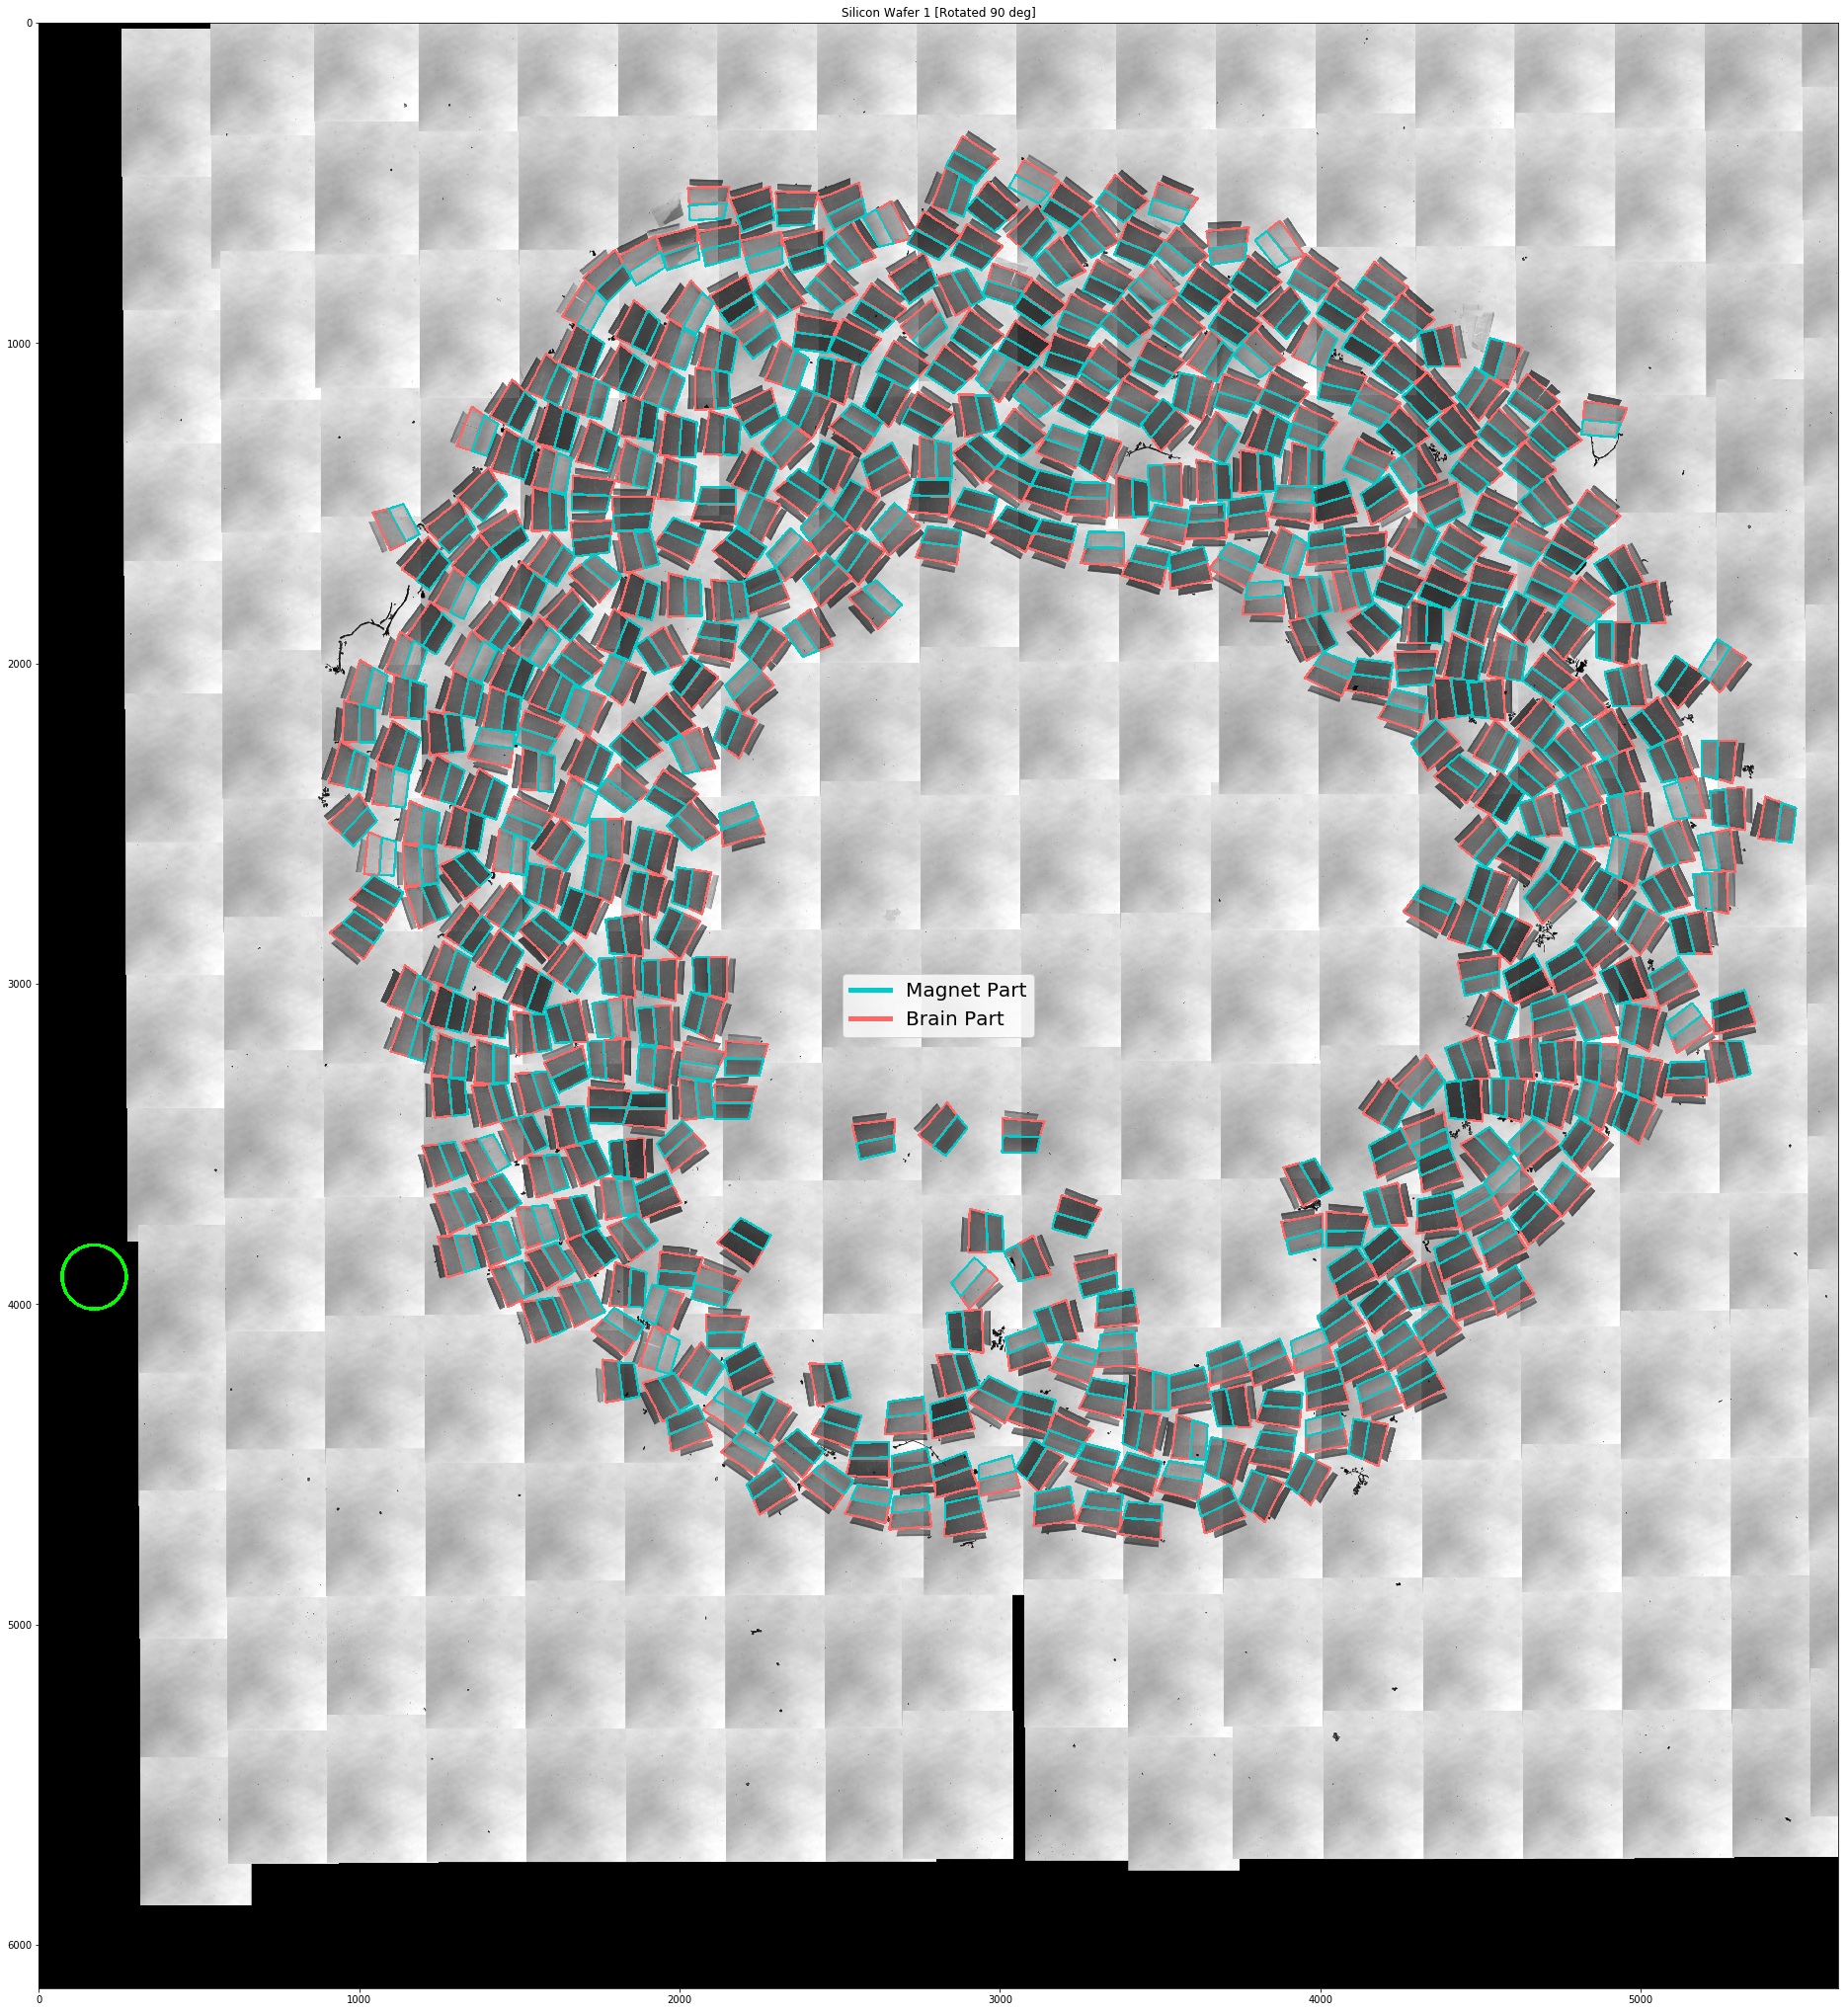

In [17]:
plt.figure(figsize=(40, 36.61))
plt.imshow(wafer_1_rot)
plt.title('Silicon Wafer 1 [Rotated 90 deg]')

legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                   Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]
plt.legend(handles=legend_elements, loc='center', fontsize=20)

plt.show()